In [1]:
import sys
sys.path.append("D:/Yuichi/MemoryAge_Transformer_xLARGE")
# the code needs to search for the modules in the parent directory

from torcheeg import transforms
from torcheeg.datasets import MemoryAgeDataset
from torcheeg.model_selection import KFoldCrossSubject
from torcheeg.models import LFP_Transformer_LARGE
from torcheeg.trainers import ClassifierTrainer

import logging
import os
import random
import time
import os
import multiprocessing
CPU_num = multiprocessing.cpu_count()

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.utils.data.dataloader import DataLoader
from scipy.signal import welch
from tqdm import tqdm

In [2]:
mice = ['ym212', 'ym213', 'ym214', 'ym215', 'ym218', 'ym219', 'ym220', 'ym222', 'ym223', 'ym224', 'ym226', 'ym227']
perturbation_features = ['ACC_theta', 'CA1_theta', 'BLA_theta', 
                         'ACC_beta', 'CA1_beta', 'BLA_beta', 
                         'ACC_sGamma', 'CA1_sGamma', 'BLA_sGamma', 
                         'ACC_fGamma', 'CA1_fGamma', 'BLA_fGamma']

channel_map = {'ACC': 0, 'CA1': 1, 'BLA': 2}
freq_map = {'theta': [6,12], 'beta': [20,30], 'sGamma': [30,50], 'fGamma': [60,90]}
fs = 1600
max_freq_disp = 100 # for spectrogram display

In [3]:
mouse = 'ym213'

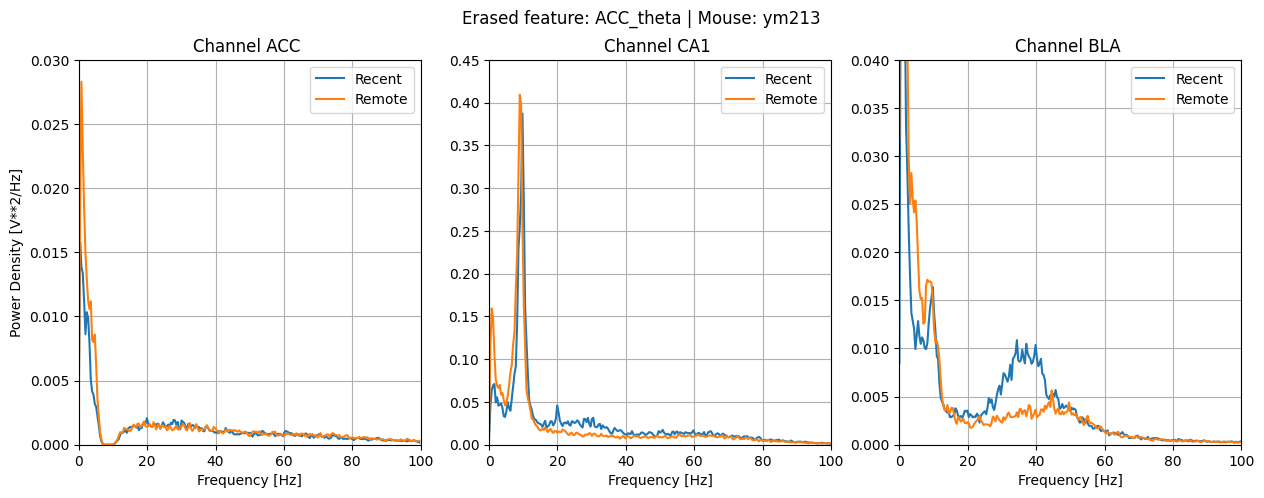

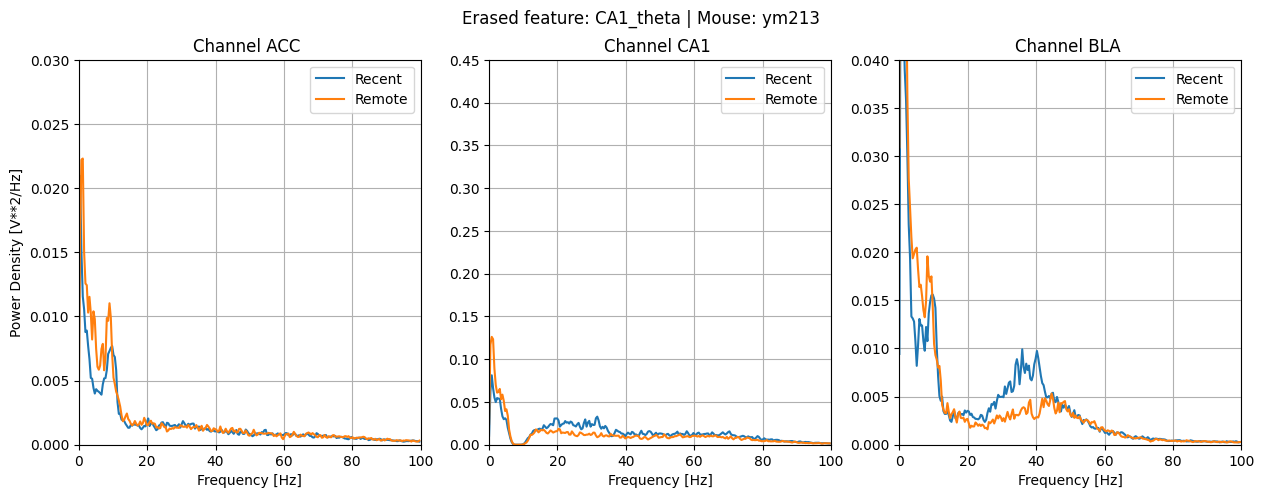

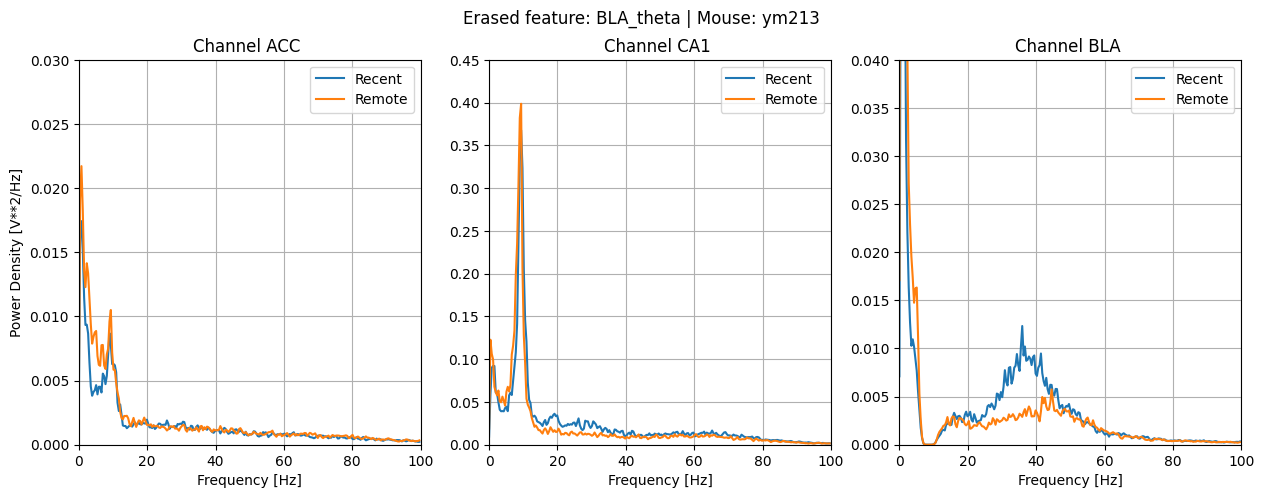

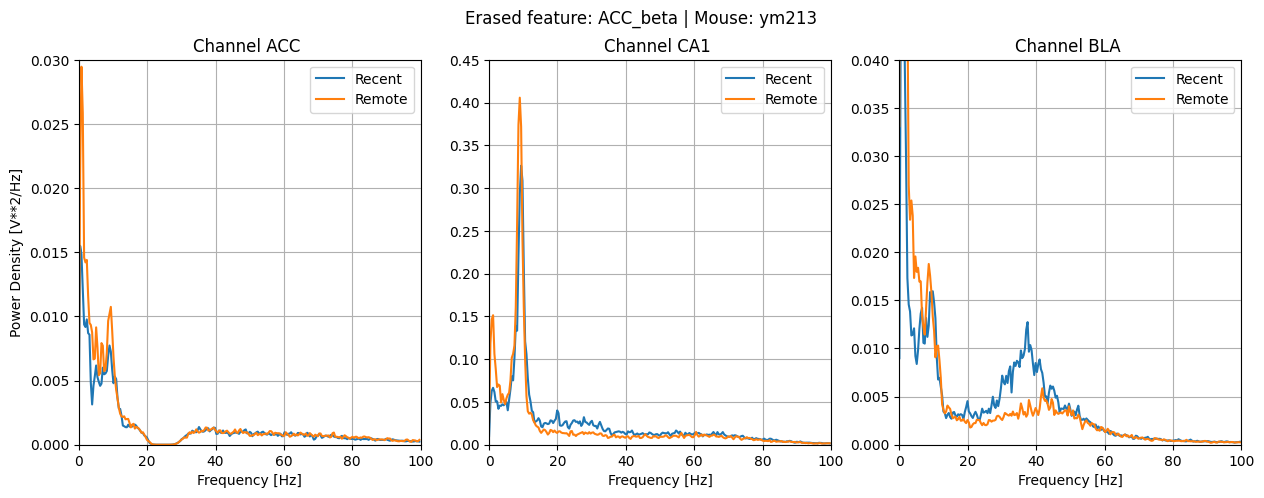

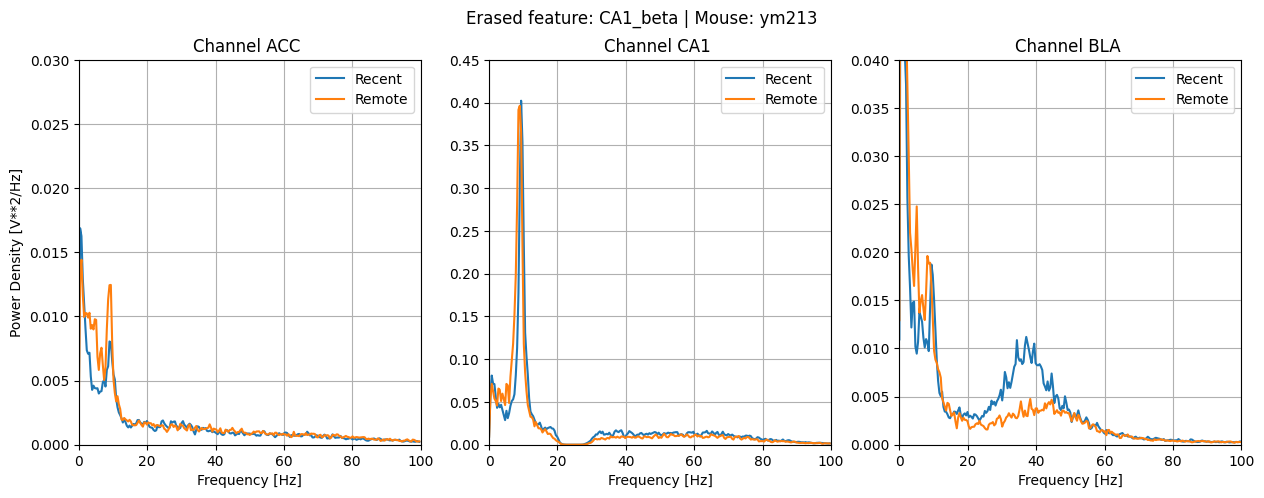

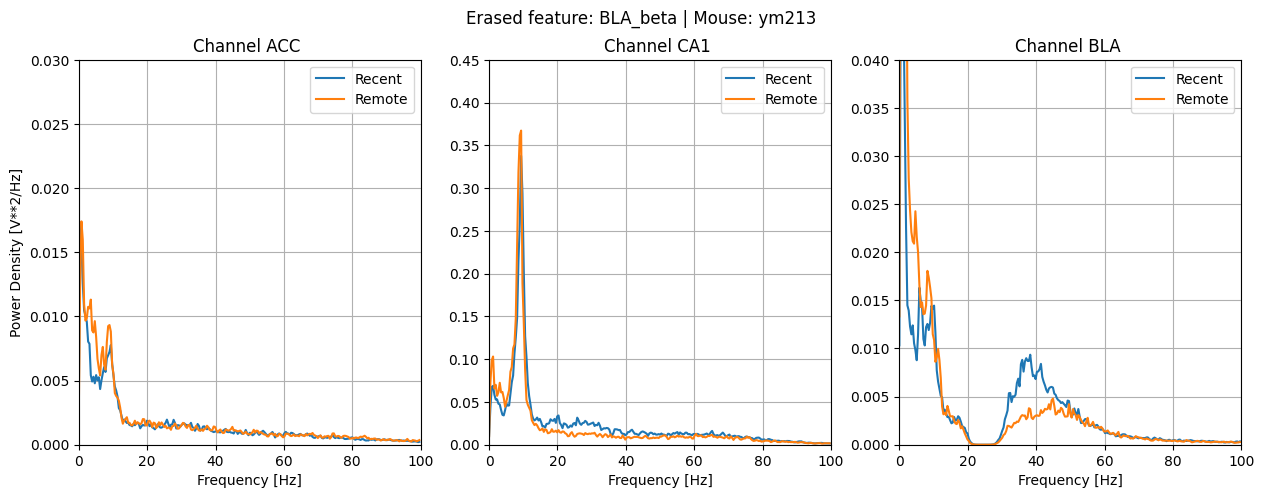

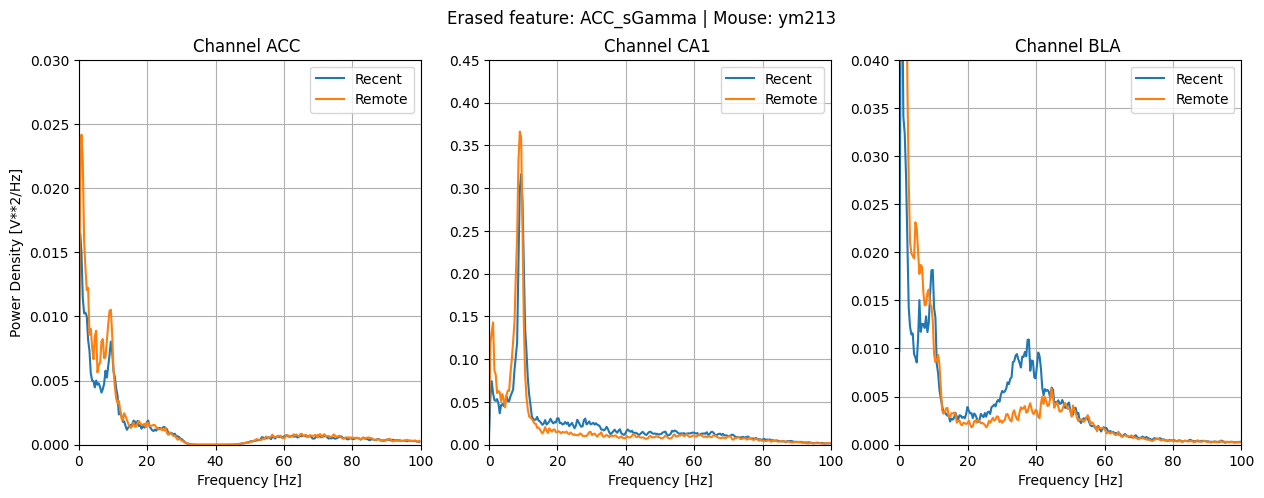

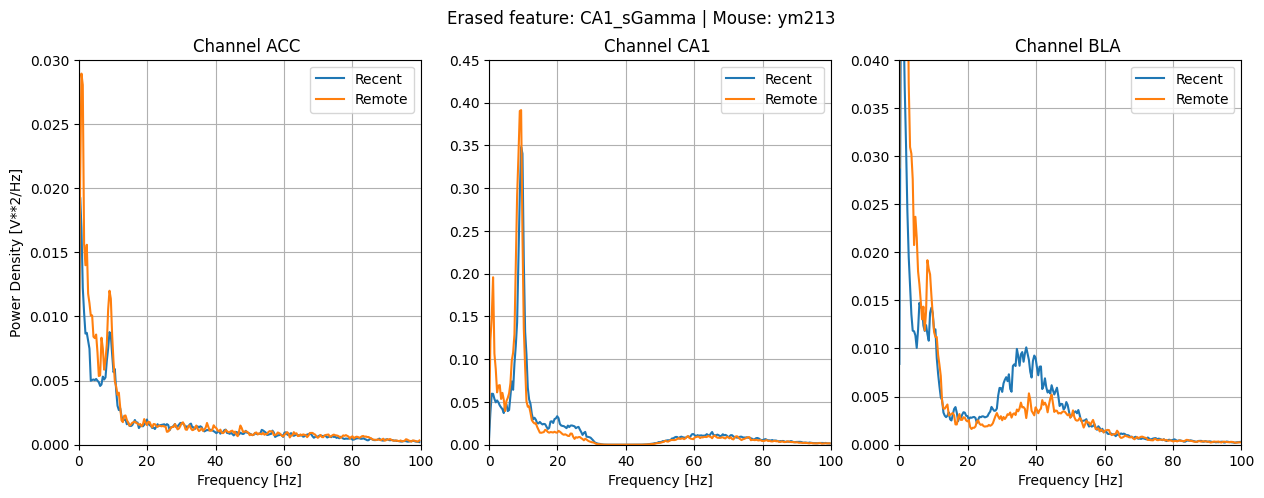

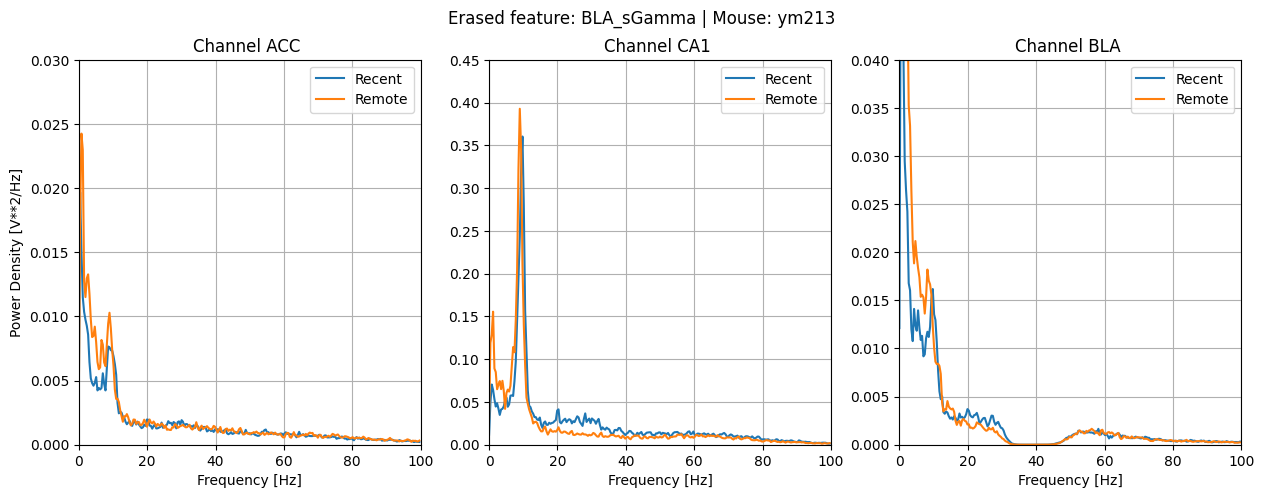

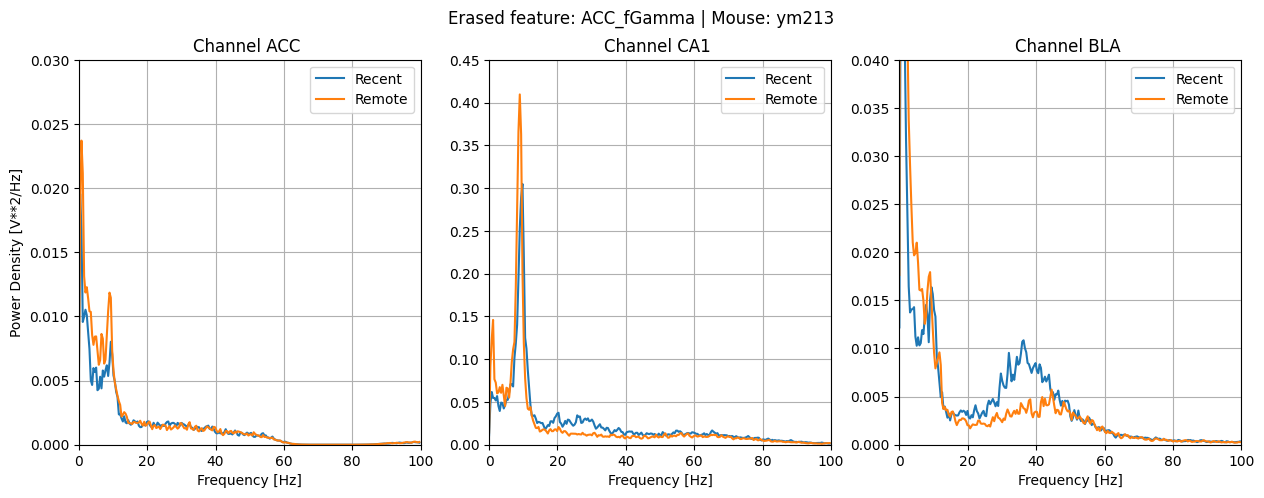

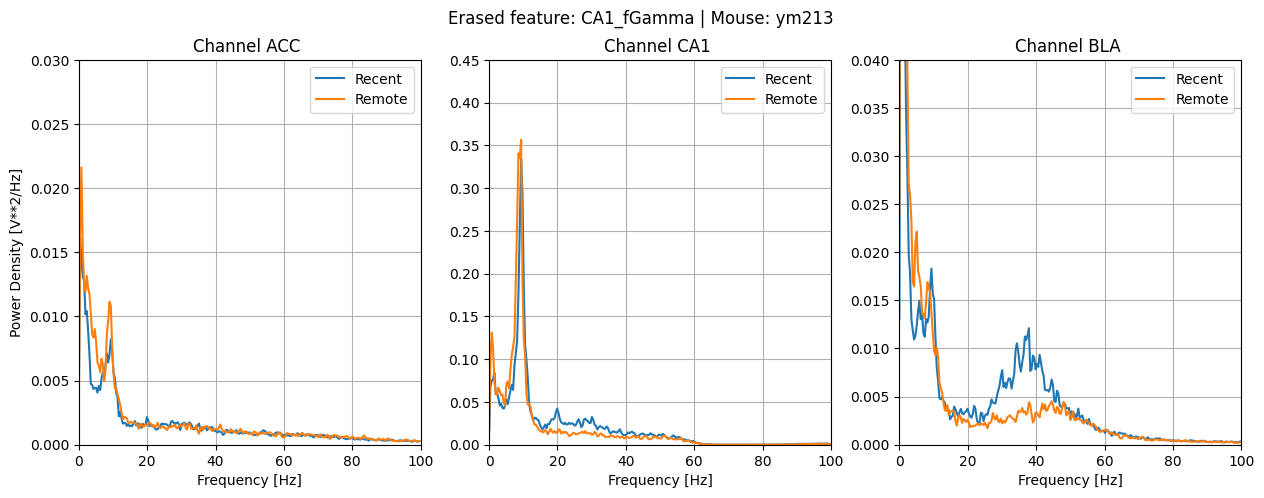

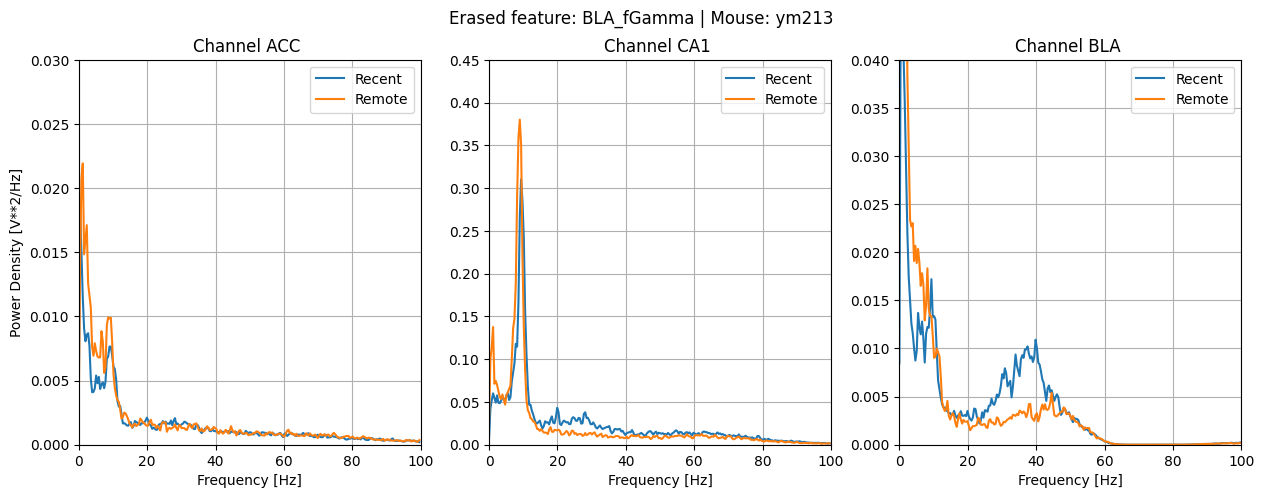

In [4]:
base_dir = './processed_dataset/perturbation_samples/'

for erased_feature in perturbation_features:

    plt.figure(figsize=(15,5))

    spectrograms = {'ACC': {'Recent': [], 'Remote': []}, 
                    'CA1': {'Recent': [], 'Remote': []}, 
                    'BLA': {'Recent': [], 'Remote': []}}

    for session in ['Recent','Remote']:

        sample_dir = os.path.join(base_dir, erased_feature, 'samples')
        sample_files = os.listdir(sample_dir)
        # the files name format is <mouse>_<session>_<index>, e.g. ym212_Recent_0
        # select all the samples of the mouse and the session
        sample_files = [f for f in sample_files if f[:5] == mouse and f[6:12] == session]
        # randomly sample 100 files from sample_files
        sample_files = random.sample(sample_files, 100)
        # full addr
        sample_files = [os.path.join(sample_dir, f) for f in sample_files]
        sample_files.sort()

        for sample_file in sample_files:

            # load pickle file
            sample = pd.read_pickle(sample_file)  # shape = (3,4096)

            # calcualte the spectrogram of each chanel in the sample
            for ch_i, ch_name in enumerate(['ACC', 'CA1', 'BLA']):
                frequencies, power_density = welch(sample[ch_i], fs=fs, nperseg=sample.shape[1])
                
                # --- Plotting the power spectral densityonly display the frequency in the range of [0, 100) Hz ---
                # the resolution of the frequency
                freq_res = frequencies[1] - frequencies[0]
                upper_idx = int(np.ceil(max_freq_disp / freq_res))
                frequencies = frequencies[:upper_idx]
                power_density = power_density[:upper_idx]

                # store the spectrogram
                spectrograms[ch_name][session].append(power_density)
        
    for ch_i, ch_name in enumerate(['ACC', 'CA1', 'BLA']):
        plt.subplot(1,3,ch_i+1)
        for session in ['Recent', 'Remote']:
            plt.plot(frequencies, np.mean(spectrograms[ch_name][session], axis=0), label=session)
        plt.title(f'Channel {ch_name} ')
        plt.xlabel('Frequency [Hz]')
        if ch_i == 0:
            plt.ylabel('Power Density [V**2/Hz]')
            plt.ylim(0, 0.03)
        elif ch_i == 1:
            plt.ylim(0, 0.45)
        else:
            plt.ylim(0, 0.04)
        plt.xlim(0, max_freq_disp)  # Plotting only the positive frequencies
        plt.grid()
        plt.legend()

    plt.suptitle(f'Erased feature: {erased_feature} | Mouse: {mouse}')
    plt.show()
    plt.close()